## Overview

## ️ Building Footprint Postprocessing

This notebook calculates geometric descriptors of building footprints and performs data cleaning.

###  Summary
- Loads building footprint data from a GeoPackage or GeoJSON.
- Computes three shape descriptors per footprint:
  - **Area**: Footprint Area (in units native to the coordinate system)
  - **Length-to-Width Ratio** (via PCA)
  - **Rectangularity**: Area / Minimum Rotated Rectangle Area
- Cleans the dataset by removing footprints with a very low area or rectangularity, and converts footprints saved as Multipolygons to polygons.
- Visualizes spatial and statistical properties:

###  Input
- path_to_file -> path to a .gpkg or .geojson with building footprints
- Assumes a valid geometry column (usually `geometry`) and a projected CRS for area calculations.

###  Output
- Modified `GeoDataFrame` with new attributes:
  - `length_width_ratio`, `convexity`, `rectangularity`, `area`
- Output pathname should be specified by the user under path_new_file


## Imports and Setup

In [20]:
import geopandas as gpd
import numpy as np
from sklearn.decomposition import PCA

from shapely.geometry import Polygon, MultiPolygon
from shapely.validation import explain_validity
import matplotlib.pyplot as plt

import os
os.chdir("C:/Github/caribbean-building-attributes")

## Parameters

In [21]:
#iso_code = "DOM"
#path_to_file = f"data/vector/{iso_code}_roof_classification.gpkg"
#path_new_file = f"data/vector/{iso_code}_roof_classification_post.gpkg"

path_to_file = f"data/ms_tiles_VCT_preds.geojson"
path_new_file = f"data/ms_tiles_VCT_preds_post.geojson"

In [22]:
# for debugging purposes
print(path_to_file)
print(os.getcwd())

data/ms_tiles_VCT_preds.geojson
C:\Github\caribbean-building-attributes


## Get building footprint attributes

In [23]:
# Load GeoJSON
gdf = gpd.read_file(path_to_file)
print(gdf.head())

# For testing purposes, we can use a subset of the data
#gdf = gdf.head(100)


   UID  ghsl_smod rurban  grid_id    filename  \
0   13         13  rural      185  13_185.tif   
1   14         13  rural      185  14_185.tif   
2   76         13  rural      185  76_185.tif   
3   77         12  rural      185  77_185.tif   
4   93         13  rural      185  93_185.tif   

                                      filepath  clean roof_pitch  \
0  data/aerial/raster/VCT/tiles_VCT/13_185.tif   True      gable   
1  data/aerial/raster/VCT/tiles_VCT/14_185.tif   True        hip   
2  data/aerial/raster/VCT/tiles_VCT/76_185.tif   True      gable   
3  data/aerial/raster/VCT/tiles_VCT/77_185.tif   True    no_roof   
4  data/aerial/raster/VCT/tiles_VCT/93_185.tif   True      gable   

   roof_pitch_prob    roof_material  roof_material_prob  \
0         0.964160    healthy_metal            0.943402   
1         0.834033    healthy_metal            0.965305   
2         0.950934    healthy_metal            0.947171   
3         0.584651    healthy_metal            0.625030   
4

In [24]:
# Check for invalid geometries in the GeoDataFrame
invalid_geoms = gdf[~gdf.is_valid]
print(f"Number of invalid geometries: {len(invalid_geoms)}")
if len(invalid_geoms) > 0:
    print(invalid_geoms)

# List indices and reasons for invalid geometries
if len(invalid_geoms) > 0:
    for idx, row in invalid_geoms.iterrows():
        reason = explain_validity(row.geometry)
        print(f"Index {idx}: {reason}")

# Remove invalid geometries from the GeoDataFrame
gdf = gdf[gdf.is_valid].copy()
print(f"Number of building footprints after removing invalid geometries: {len(gdf)}")

Number of invalid geometries: 0
Number of building footprints after removing invalid geometries: 43061


In [25]:
# Building footprints are saved as multi-part geometries, check and convert if necessary

# Count types
type_counts = gdf.geometry.apply(lambda geom: type(geom).__name__).value_counts()
print(type_counts)

# Get number of parts in each geometry
gdf["n_parts"] = gdf.geometry.apply(
    lambda geom: len(geom.geoms) if isinstance(geom, MultiPolygon) else 1
)

# Count how many are single-part vs multi-part
part_counts = gdf["n_parts"].value_counts().sort_index()
print(part_counts)

# If a MultiPolygon has only one part, convert it to a Polygon
# This is useful for simplifying the dataset and ensuring consistency
def convert_to_polygon_if_singlepart(geom):
    if isinstance(geom, MultiPolygon) and len(geom.geoms) == 1:
        return geom.geoms[0]
    return geom

gdf["geometry"] = gdf.geometry.apply(convert_to_polygon_if_singlepart)

# Also adding a check to ensure that the geometries are in projected coordinates
# Check if CRS is geographic (units in degrees) and reproject if necessary
if gdf.crs and gdf.crs.is_geographic:
    utm_crs = gdf.estimate_utm_crs()
    gdf = gdf.to_crs(utm_crs)
    print(f"Reprojected to UTM CRS: {utm_crs}")


geometry
Polygon    43061
Name: count, dtype: int64
n_parts
1    43061
Name: count, dtype: int64
Reprojected to UTM CRS: EPSG:32620


In [26]:
# According to the OECS Building Code: long, narrow building should be avoided by limiting the lentgth-to-width ratio to 3:1.
# This function calculates the length-to-width ratio of a building footprint using PCA.
# The ratio is defined as the length of the longest principal axis divided by the length of the shortest principal axis.

def length_width_ratio(geometry):
    # Get exterior coordinates of polygon
    coords = np.array(geometry.exterior.coords)
    
    # Center the coordinates
    coords_centered = coords - coords.mean(axis=0)
    
    # PCA to get the orientation and spread
    pca = PCA(n_components=2)
    pca.fit(coords_centered)
    
    # Lengths of the principal axes (explained variance is proportional to length²)
    axis_lengths = 2 * np.sqrt(pca.explained_variance_)
    
    # Avoid division by zero
    if axis_lengths[1] == 0:
        return np.nan
    
    return axis_lengths[0] / axis_lengths[1]

# Calculate ratio for each building
gdf["length_width_ratio"] = gdf.geometry.apply(length_width_ratio)

# Compute areas (in projected units, e.g. square meters)
gdf["area"] = gdf.geometry.area

print(gdf.head())

   UID  ghsl_smod rurban  grid_id    filename  \
0   13         13  rural      185  13_185.tif   
1   14         13  rural      185  14_185.tif   
2   76         13  rural      185  76_185.tif   
3   77         12  rural      185  77_185.tif   
4   93         13  rural      185  93_185.tif   

                                      filepath  clean roof_pitch  \
0  data/aerial/raster/VCT/tiles_VCT/13_185.tif   True      gable   
1  data/aerial/raster/VCT/tiles_VCT/14_185.tif   True        hip   
2  data/aerial/raster/VCT/tiles_VCT/76_185.tif   True      gable   
3  data/aerial/raster/VCT/tiles_VCT/77_185.tif   True    no_roof   
4  data/aerial/raster/VCT/tiles_VCT/93_185.tif   True      gable   

   roof_pitch_prob    roof_material  roof_material_prob  \
0         0.964160    healthy_metal            0.943402   
1         0.834033    healthy_metal            0.965305   
2         0.950934    healthy_metal            0.947171   
3         0.584651    healthy_metal            0.625030   
4

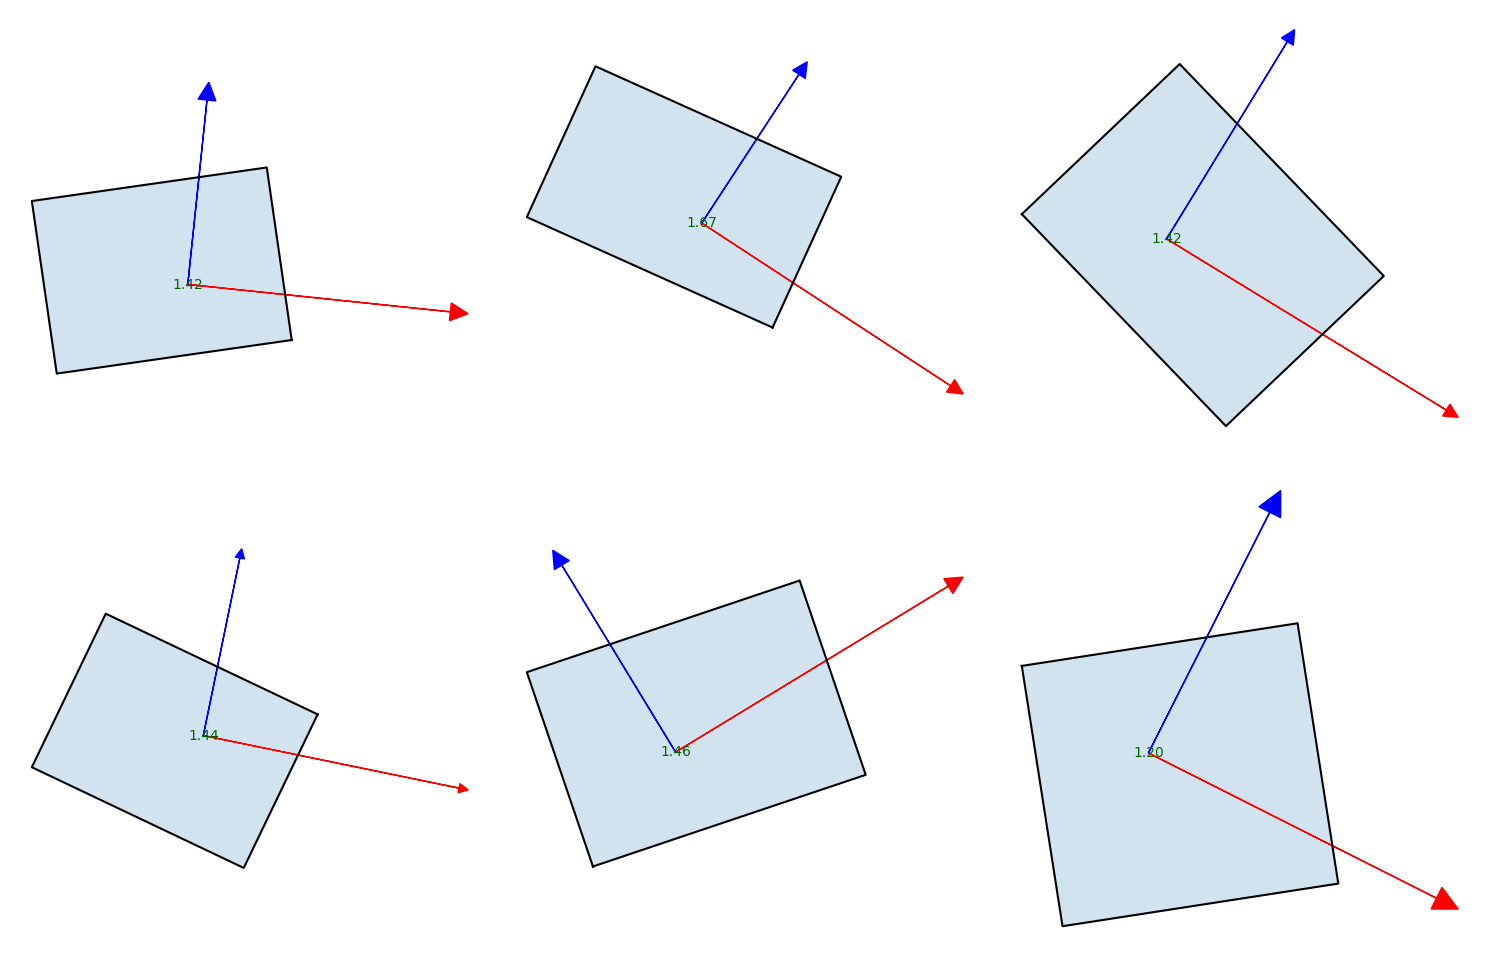

In [27]:
# Plot some examples of buildings with their length-to-width ratio
def drop_z(geom):
    if isinstance(geom, Polygon):
        return Polygon([(x, y) for x, y, *_ in geom.exterior.coords])
    else:
        return geom

def plot_building_with_pca(geometry, ratio, ax):
    # Drop Z if present
    geometry = drop_z(geometry)

    coords = np.array(geometry.exterior.coords)
    coords_centered = coords - coords.mean(axis=0)

    pca = PCA(n_components=2)
    pca.fit(coords_centered)

    # Get principal axes
    origin = coords.mean(axis=0)
    vectors = pca.components_ * 2 * np.sqrt(pca.explained_variance_).reshape(-1, 1)

    # Plot footprint
    ax.plot(*coords.T, color="black")
    ax.fill(*coords.T, alpha=0.2)

    # Plot PCA axes
    for i, vec in enumerate(vectors):
        ax.arrow(origin[0], origin[1], vec[0], vec[1],
                 head_width=0.5, head_length=0.5, fc='red' if i == 0 else 'blue', ec='red' if i == 0 else 'blue')

    # Annotate ratio
    ax.text(origin[0], origin[1], f"{ratio:.2f}", fontsize=10, ha="center", va="center", color="darkgreen")
    ax.set_aspect('equal')
    ax.axis('off')

# Plot a sample of buildings
sample = gdf.dropna(subset=["length_width_ratio"]).sample(6, random_state=1)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, (geom, ratio) in enumerate(zip(sample.geometry, sample.length_width_ratio)):
    plot_building_with_pca(geom, ratio, axs[i])

plt.tight_layout()
plt.show()

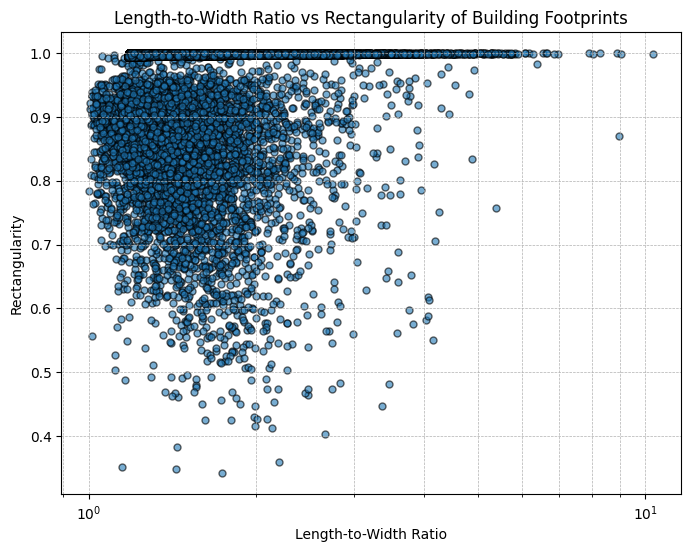

In [28]:
# Compute convexivity and rectangularity for each building footprint as a proxy for building footprint regularity.
# Convexity is the ratio of the area of the building footprint to the area of its convex hull.
# Rectangularity is the ratio of the area of the building footprint to the area of its minimum rotated rectangle.
def add_shape_descriptors(gdf):
    gdf["rectangularity"] = gdf.geometry.apply(
        lambda g: g.area / g.minimum_rotated_rectangle.area if g and g.minimum_rotated_rectangle.area > 0 else None
    )
    return gdf

# Plot results
def plot_lw_vs_rectangularity(gdf):
    plt.figure(figsize=(8, 6))
    plt.scatter(gdf["length_width_ratio"], gdf["rectangularity"], alpha=0.6, s=25, edgecolor='k')
    plt.xscale("log")
    plt.xlabel("Length-to-Width Ratio")
    plt.ylabel("Rectangularity")
    plt.title("Length-to-Width Ratio vs Rectangularity of Building Footprints")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

gdf = add_shape_descriptors(gdf)
plot_lw_vs_rectangularity(gdf)

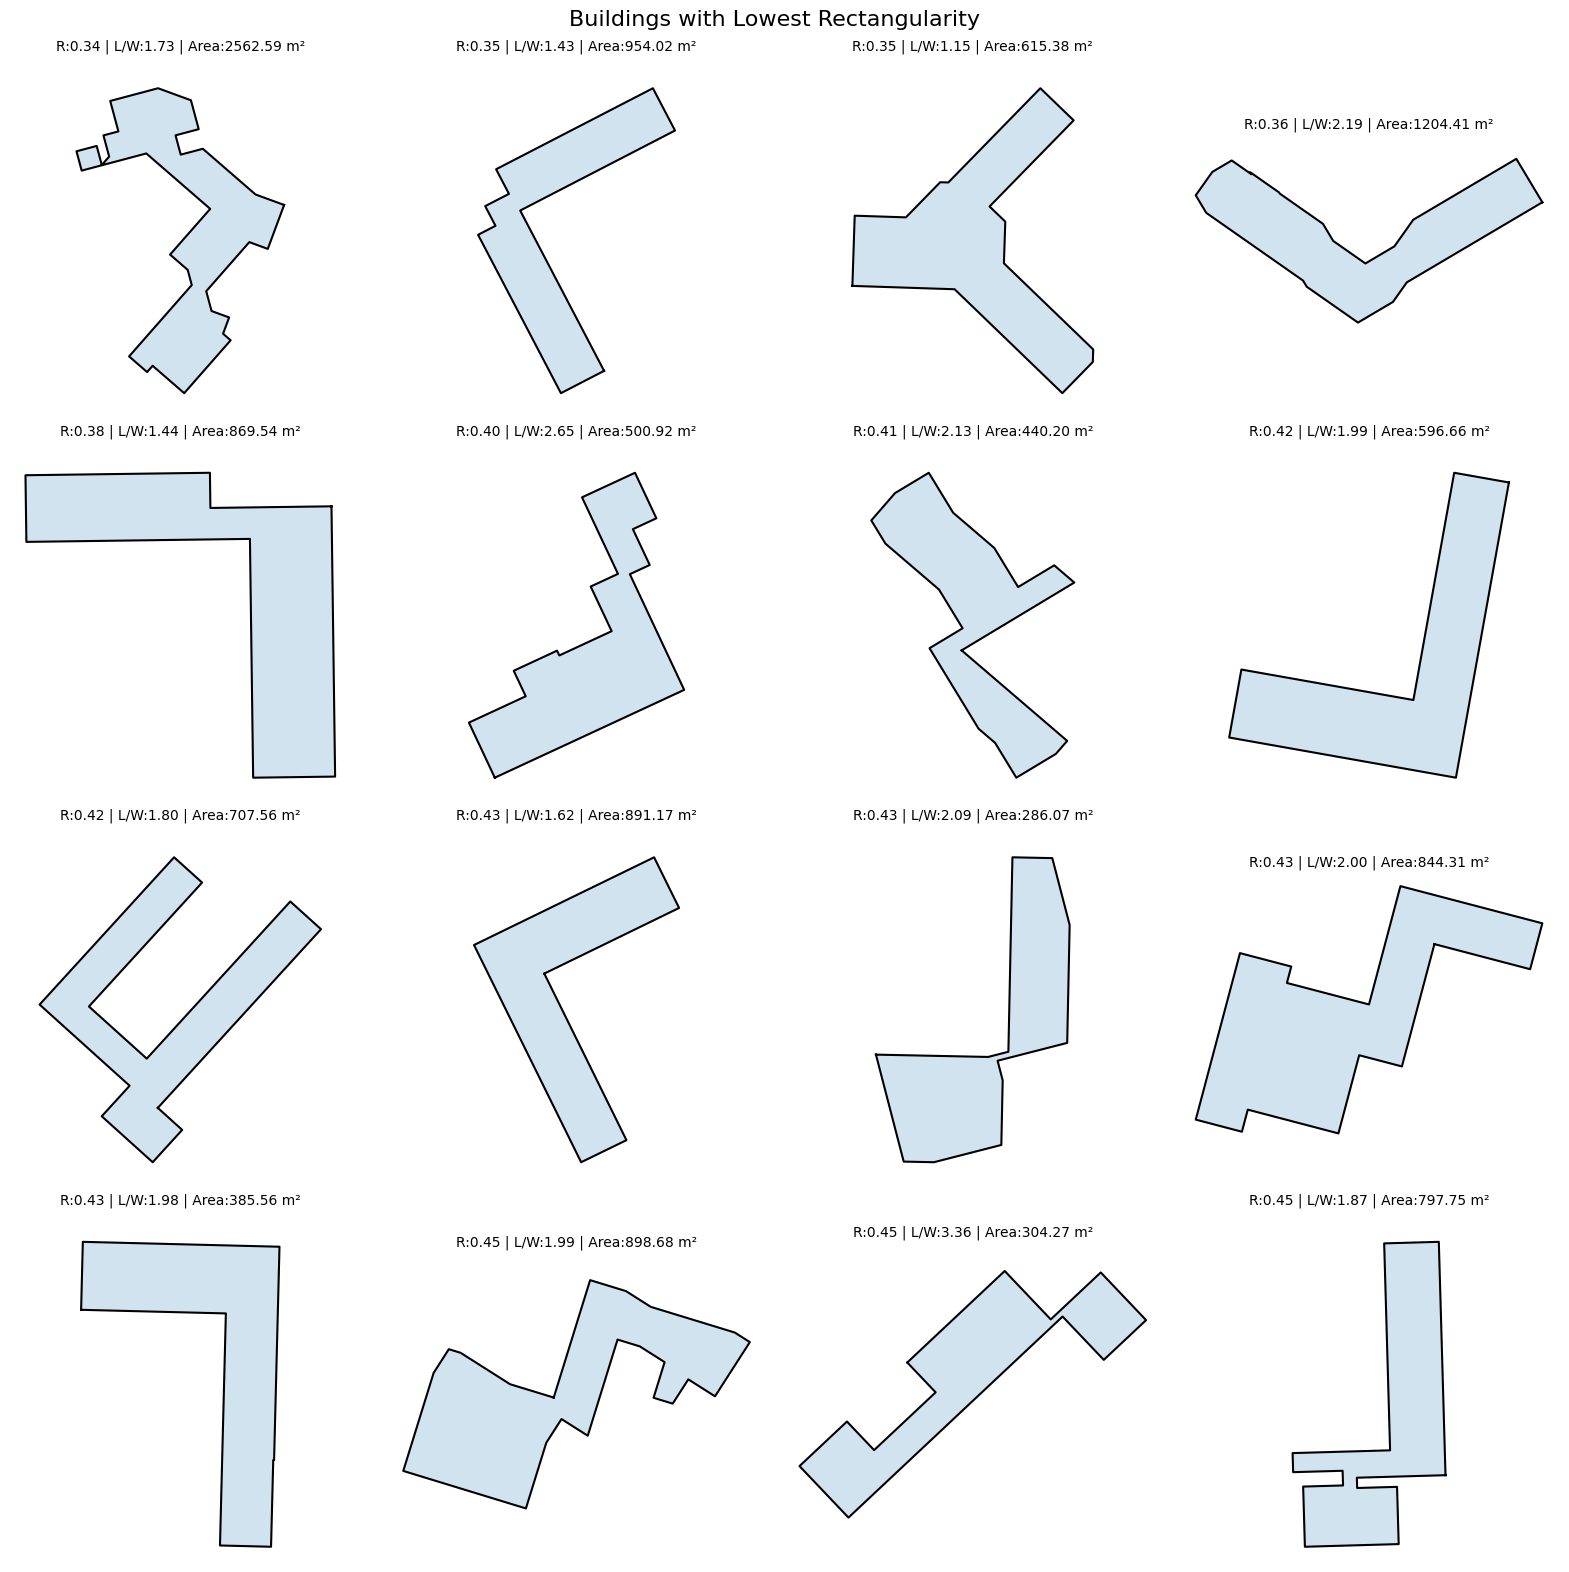

In [29]:
# Plot examples of buildings with low rectangularity

# Select how many examples you want to plot
n = 16

# Ensure we have enough valid data
if len(gdf) < n:
    raise ValueError(f"Not enough valid geometries to plot {n} examples.")

# Identify n lowest convexity + rectangularity buildings
gdf_valid = gdf.dropna(subset=["length_width_ratio", "rectangularity"]).copy()
gdf_low_rect = gdf_valid.nsmallest(n, "rectangularity")

# Plotting function (only rectangularity shown)
def plot_building_shape(ax, geometry, rectangularity, length_width_ratio, area):
    coords = np.array([(x, y) for x, y, *_ in geometry.exterior.coords])
    ax.plot(*coords.T, color="black")
    ax.fill(*coords.T, alpha=0.2)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(f"R:{rectangularity:.2f} | L/W:{length_width_ratio:.2f} | Area:{area:.2f} m²", fontsize=10)

# Plot group
cols = 4
rows = (n + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axs = axs.flatten()

for i, row in enumerate(gdf_low_rect.itertuples()):
    plot_building_shape(axs[i], row.geometry, row.rectangularity, row.length_width_ratio, row.area)

plt.suptitle("Buildings with Lowest Rectangularity", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


## Remove sliver polygons

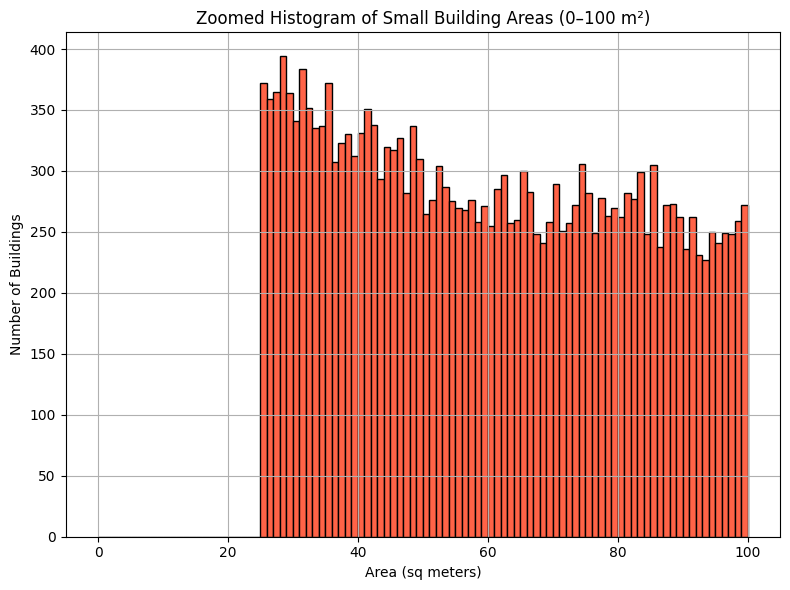

In [30]:


# Plot zoomed-in histogram to detect slivers
plt.figure(figsize=(8, 6))
plt.hist(gdf["area"], bins=100, color="tomato", edgecolor="black", range=(0, 100))
plt.xlabel("Area (sq meters)")
plt.ylabel("Number of Buildings")
plt.title("Zoomed Histogram of Small Building Areas (0–100 m²)")
plt.grid(True)
plt.tight_layout()
plt.show()

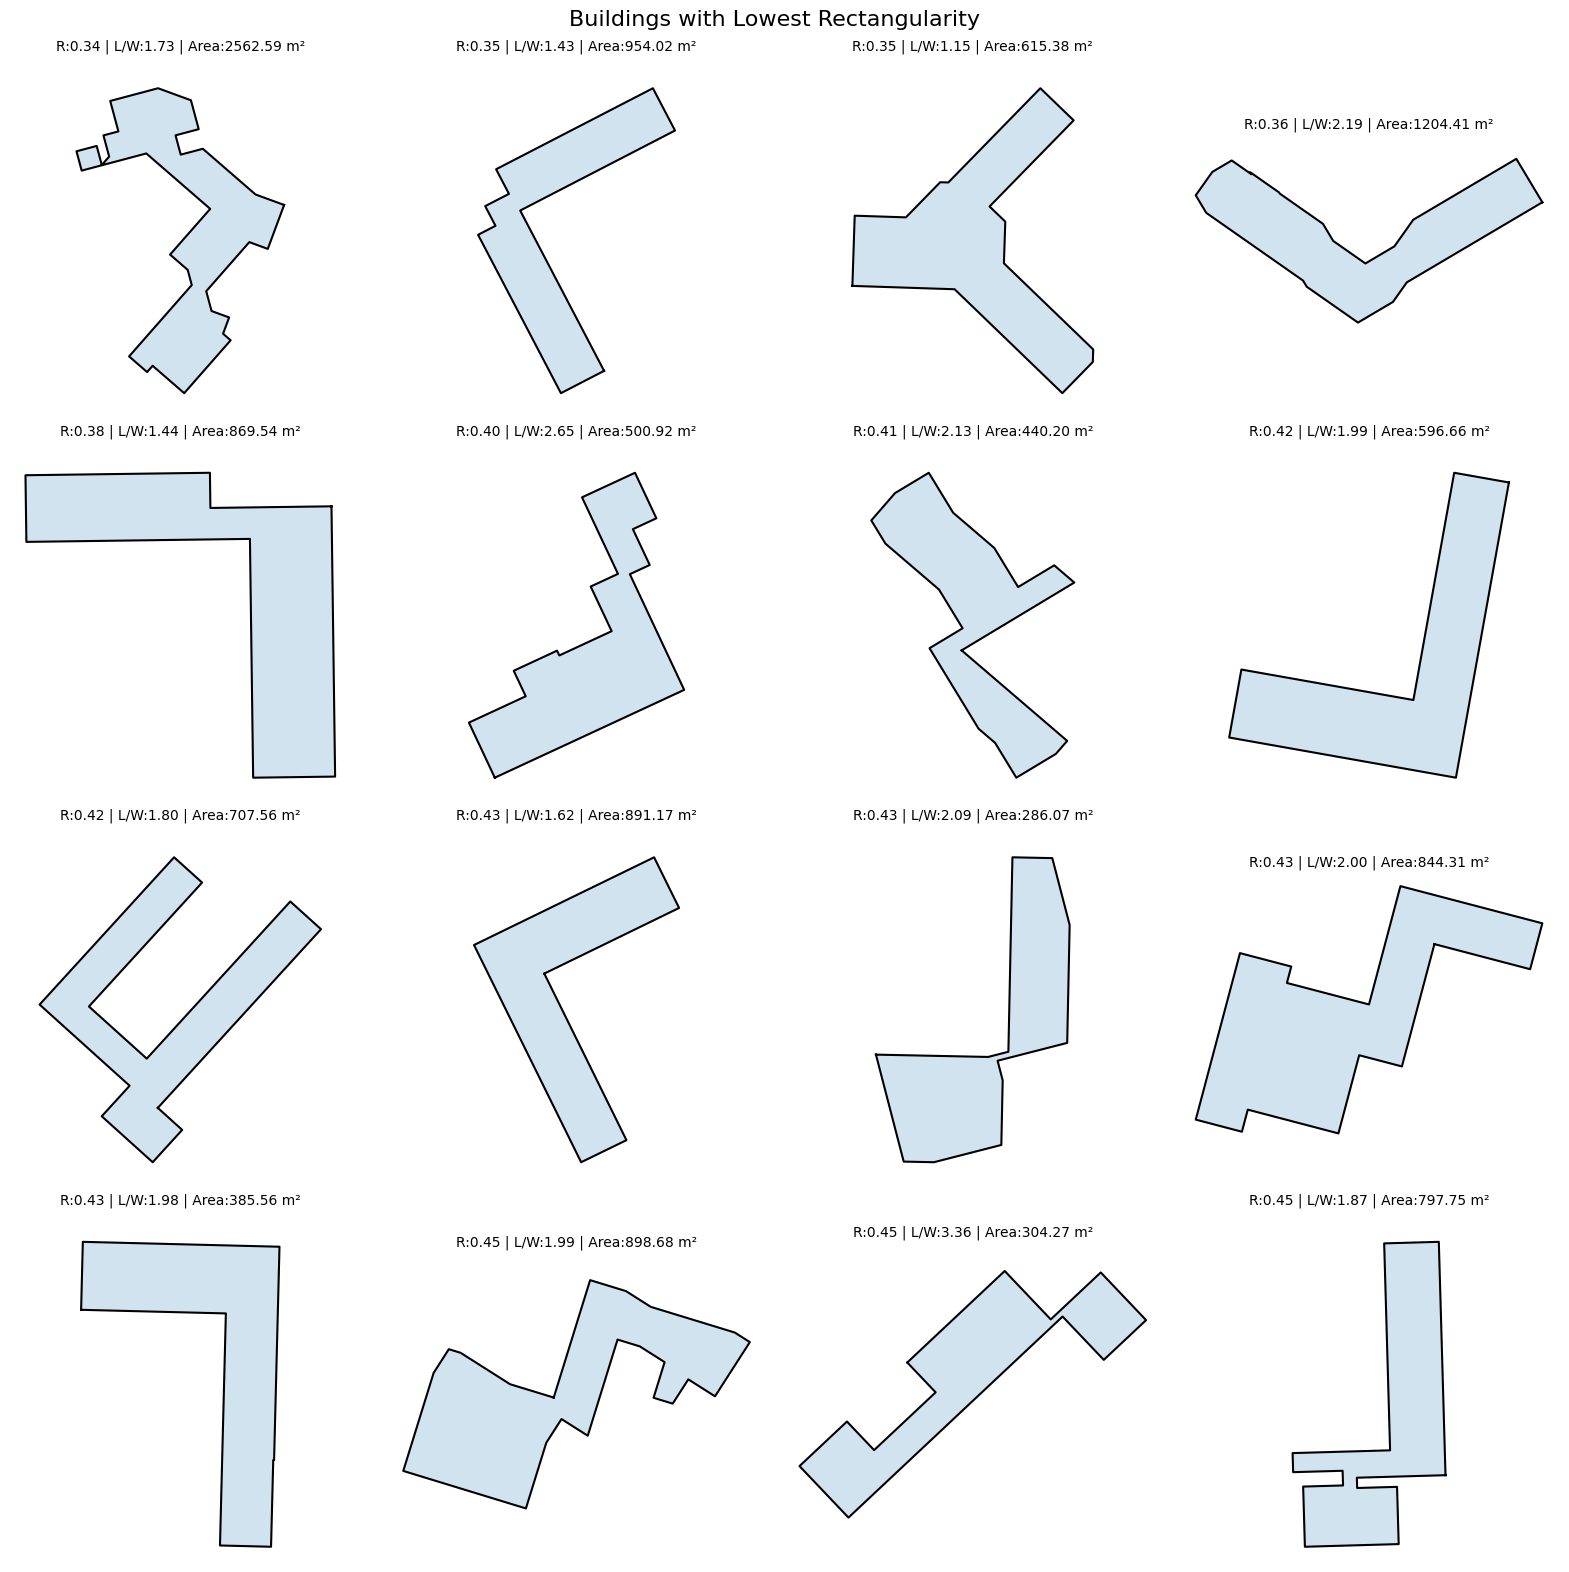

In [31]:
# Remove buildings that are too small or have low rectangularity
# This is a heuristic to filter out slivers and very unlikely building shapes.
gdf_cleaned = gdf[(gdf["area"] > 1.5) & (gdf["rectangularity"] > 0.2)]

# Plot the results after cleaning
gdf_selected = gdf_cleaned.nsmallest(n, "rectangularity")

# Plot group
cols = 4
rows = (n + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axs = axs.flatten()

for i, row in enumerate(gdf_selected.itertuples()):
    plot_building_shape(axs[i], row.geometry, row.rectangularity, row.length_width_ratio, row.area)

plt.suptitle("Buildings with Lowest Rectangularity", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()

In [32]:
print(f"Number of building footprints: {len(gdf)}")
print(f"Number of building footprints after cleaning: {len(gdf_cleaned)}")


Number of building footprints: 43061
Number of building footprints after cleaning: 43061


## Save the results

In [33]:
# Round selected descriptors
gdf["rectangularity"] = gdf["rectangularity"].round(2)
gdf["length_width_ratio"] = gdf["length_width_ratio"].round(2)

# Save result (optional)
gdf_cleaned.to_file(path_new_file, driver="GeoJSON")